In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def windowed_dataset(series, window_size, batch_size, shuffle):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1][2]))
    return ds.batch(batch_size).prefetch(1)

In [3]:
with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [4]:
list(data.keys())[:3]

['KRW-BTT', 'KRW-XEC', 'KRW-IQ']

In [5]:
btt = data['KRW-BTT']

In [6]:
btt.set_index('candle_date_time_kst', inplace = True)

Text(0, 0.5, 'price')

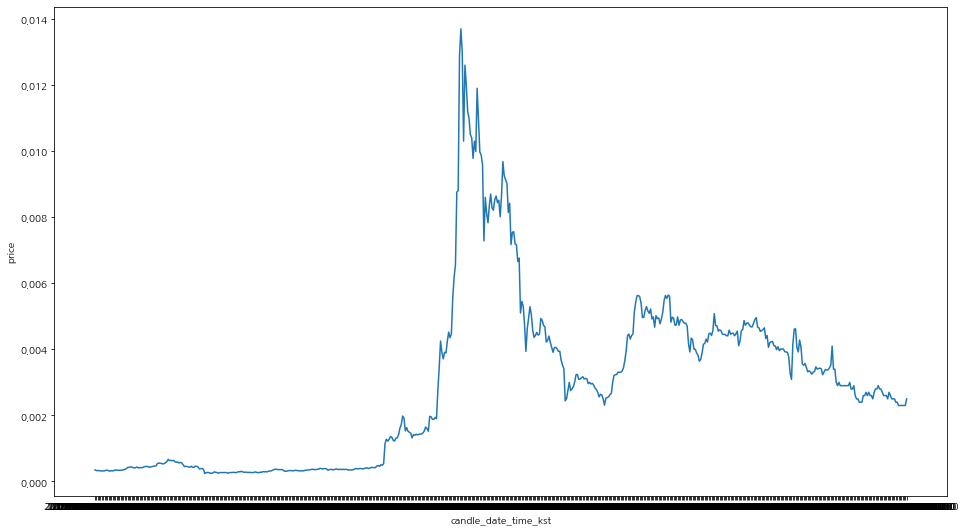

In [7]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=btt['trade_price'], x=btt.index)
plt.xlabel('candle_date_time_kst')
plt.ylabel('price')

In [8]:
WINDOW_SIZE = 20
BATCH_SIZE = 32

In [9]:
scaler = MinMaxScaler()
scale_cols = ['change_rate', 'candle_acc_trade_volume', 'trade_price']
scaled = scaler.fit_transform(btt[scale_cols])

In [10]:
df = pd.DataFrame(scaled, columns = scale_cols)

In [11]:
train_size = .8
n_train = int(np.floor(df.shape[0] * train_size))

In [12]:
train = scaled[:n_train]
test = scaled[n_train - WINDOW_SIZE:]

In [13]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, False)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential(
    [
        Conv1D(filters = 64, 
               kernel_size = 3, 
               padding = 'causal', 
               activation = 'relu', 
               input_shape = [WINDOW_SIZE, 3]
        ),
        LSTM(16, activation = 'tanh'),
        Dense(1)
    ]
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            640       
                                                                 
 lstm_2 (LSTM)               (None, 16)                5184      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,841
Trainable params: 5,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'btt_with_volume_ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, ]) # earlystopping

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

## Plot list

In [ ]:
pred_plot = np.concatenate((test[WINDOW_SIZE:,0:2], pred), axis = 1)
pred_plot = np.concatenate((train, pred_plot), axis = 0)
pred_plot = scaler.inverse_transform(pred_plot)[:, 2]
# 원래 데이터를 그대로 사용
actual_plot = scaler.inverse_transform(np.concatenate((train, test[WINDOW_SIZE:, :]), axis = 0))[:, 2]

In [ ]:
actual_plot.shape

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(pred_plot, label='prediction')
plt.plot(actual_plot, label='actual')
plt.axvline(x = train.shape[0], c = 'r', linestyle = '--')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()

In [ ]:
print(f'sMAPE = {smape(actual_plot[train.shape[0]:], pred_plot[train.shape[0]:])}')

In [ ]:
import pickle 

with open('../data/crypto_currency_oot.pickle', 'rb') as f:
    oot_data = pickle.load(f)

In [ ]:
oot_btt = oot_data['KRW-BTT']

In [ ]:
oot_scaled = scaler.transform(oot_btt[scale_cols])
oot_scaled = np.concatenate((test[-WINDOW_SIZE:, :], oot_scaled), axis = 0)

In [ ]:
type(oot_scaled)

In [ ]:
oot_test_data = windowed_dataset(oot_scaled, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
oot_pred = model.predict(oot_test_data)

In [ ]:
oot_pred.shape

In [ ]:
# oot pred 데이터 만들기
oot_pred_plot = np.concatenate((oot_scaled[WINDOW_SIZE:,0:2], oot_pred), axis = 1)
# pred 데이터 만들기
pred_plot = np.concatenate((test[WINDOW_SIZE:,0:2], pred), axis = 1)
# 모두 합해서 역변환하기
oot_pred_plot = scaler.inverse_transform(np.concatenate((train, pred_plot, oot_pred_plot)))[:, 2]
# Actual 데이터 만들기
oot_actual_plot = scaler.inverse_transform(np.concatenate((train, test[WINDOW_SIZE:, :], oot_scaled[WINDOW_SIZE:, :])))[:, 2]

In [ ]:
oot_pred_plot.shape

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(oot_pred_plot, label='prediction')
plt.plot(oot_actual_plot, label='actual')
plt.axvline(x = train.shape[0], c = 'r', linestyle = '--')
plt.axvline(x = train.shape[0] + test.shape[0], c = 'b', linestyle = '--')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()

In [ ]:
print(f'sMAPE = {smape(oot_actual_plot[train.shape[0] + test.shape[0]:], oot_pred_plot[train.shape[0] + test.shape[0]:])}')